In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, make_scorer
from imblearn.metrics import specificity_score

from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

In [2]:
protien = pd.read_csv("../sequences_training.txt", header=None)
protien.columns = ["protien_seq", "class"]
protien.head()

,protien_seq,class
0,MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...,nonDRNA
1,MEQKKMKYLENLVGKTPMLELIFDYKGEERRIFVKNESYNLTGSIK...,nonDRNA
2,MTILFQLALAALVILSFVMVIGVPVAYASPQDWDRSKQLIFLGSGL...,nonDRNA
3,MSKIERISAFLNDKEVDMTFITNPTTLNYLTGLAIDPHERIAGLMI...,nonDRNA
4,MSDQQQPPVYKIALGIEYDGSKYYGWQRQNEVRSVQEKLEKALSQV...,RNA


In [3]:
import sys

sys.path.append('../')

from FeatureExtraction import extract_features, clean_data

In [4]:
clean_protiens = clean_data(protien)
bio_features = extract_features(clean_protiens)
bio_features.head()

,class,protien_len,mol_weighht,isoelectric_point,Helix,Turn,Sheet,type1,type2,type3,...,N,P,Q,R,S,T,V,W,Y,pos_neg_rat
0,nonDRNA,155,17596.7878,-0.630968,0.341935,0.238710,0.329032,73,37,19,...,4.516129,3.225806,5.161290,6.451613,2.580645,6.451613,5.806452,3.870968,3.225806,1.368420
1,nonDRNA,336,37260.7955,-0.201190,0.366071,0.303571,0.366071,168,75,43,...,5.952381,3.273810,1.190476,2.976190,6.845238,4.166667,6.547619,0.297619,3.571429,1.162790
2,nonDRNA,62,6764.1710,1.579032,0.322581,0.209677,0.580645,48,10,2,...,1.612903,3.225806,4.838710,1.612903,6.451613,1.612903,17.741935,3.225806,1.612903,0.999995
3,nonDRNA,362,39968.9808,-0.141713,0.334254,0.281768,0.356354,187,74,57,...,4.419890,4.143646,2.209945,3.314917,4.696133,5.524862,6.906077,0.276243,2.486188,0.771930
4,RNA,270,30399.2510,-0.314074,0.300000,0.248148,0.355556,138,62,28,...,4.074074,5.555556,4.444444,7.407407,3.703704,5.185185,9.629630,1.851852,4.444444,1.499999


In [6]:
gb_baseline = Pipeline([
    ('preprocessor', 'passthrough'),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

X = bio_features.drop(columns=['class'])
y = bio_features['class']

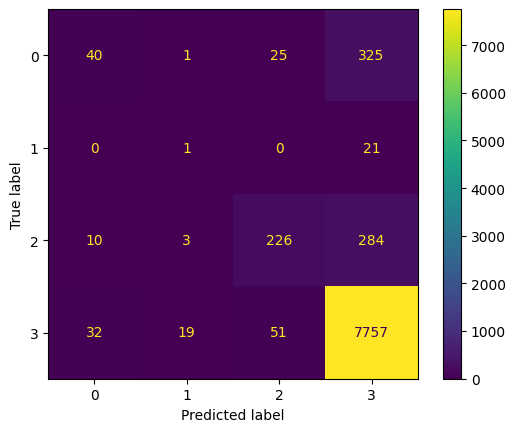

In [7]:
y_pred = cross_val_predict(gb_baseline, X, y, cv=5)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [8]:
def prec_nonDRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def prec_DNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def prec_RNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def prec_DRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)

def rec_nonDRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def rec_DNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def rec_RNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def rec_DRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)

def spe_nonDRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['nonDRNA'])[0]

def spe_DNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['DNA'])[0]

def spe_RNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['RNA'])[0]

def spe_DRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['DRNA'])[0]

In [9]:
scoring = {
        'precision_nonDRNA': make_scorer(prec_nonDRNA),
        'precision_DNA':     make_scorer(prec_DNA),
        'precision_RNA':     make_scorer(prec_RNA),
        'precision_DRNA':    make_scorer(prec_DRNA),
        'specificity_nonDRNA':    make_scorer(spe_nonDRNA),
        'specificity_DNA':        make_scorer(spe_DNA),
        'specificity_RNA':        make_scorer(spe_RNA),
        'specificity_DRNA':       make_scorer(spe_DRNA),
        'recall_nonDRNA':    make_scorer(rec_nonDRNA),
        'recall_DNA':        make_scorer(rec_DNA),
        'recall_RNA':        make_scorer(rec_RNA),
        'recall_DRNA':       make_scorer(rec_DRNA),
}

In [10]:
params = {"sampler": ['passthrough', RandomOverSampler(random_state=42), ADASYN(random_state=42), SMOTE(random_state=42), TomekLinks(), RandomUnderSampler(random_state=42)],
         'preprocessor': ['passthrough', StandardScaler(), MinMaxScaler(), QuantileTransformer()]}

gb_preprocess_test = Pipeline([
    ('sampler', 'passthrough'),
    ('preprocessor', 'passthrough'),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gs = GridSearchCV(gb_preprocess_test, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)


In [11]:
gs.fit(X,y)

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (68). n_quantiles is set to n_samples.
 

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'preprocessor': ['passthrough', StandardScaler(), ...], 'sampler': ['passthrough', RandomOverSam...ndom_state=42), ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [12]:
results = pd.DataFrame(gs.cv_results_)

In [13]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor,param_sampler,params,split0_test_precision_nonDRNA,split1_test_precision_nonDRNA,split2_test_precision_nonDRNA,...,std_test_recall_RNA,rank_test_recall_RNA,split0_test_recall_DRNA,split1_test_recall_DRNA,split2_test_recall_DRNA,split3_test_recall_DRNA,split4_test_recall_DRNA,mean_test_recall_DRNA,std_test_recall_DRNA,rank_test_recall_DRNA
0,27.825576,0.332223,0.083966,0.006258,passthrough,passthrough,"{'preprocessor': 'passthrough', 'sampler': 'pa...",0.928230,0.926278,0.920522,...,0.060885,19,0.00,0.00,0.00,0.2,0.0,0.04,0.080000,17
1,54.370942,1.161985,0.084871,0.014662,passthrough,RandomOverSampler(random_state=42),"{'preprocessor': 'passthrough', 'sampler': Ran...",0.966226,0.967576,0.959077,...,0.039980,4,0.00,0.25,0.00,0.2,0.0,0.09,0.111355,13
2,123.253731,0.532149,0.082000,0.006329,passthrough,ADASYN(random_state=42),"{'preprocessor': 'passthrough', 'sampler': ADA...",0.967939,0.963247,0.953574,...,0.050721,11,0.00,0.25,0.00,0.4,0.0,0.13,0.166132,5
3,121.528357,1.862677,0.080448,0.004803,passthrough,SMOTE(random_state=42),"{'preprocessor': 'passthrough', 'sampler': SMO...",0.970023,0.964150,0.952733,...,0.055698,7,0.00,0.25,0.00,0.4,0.0,0.13,0.166132,5
4,25.642644,0.133443,0.073257,0.004373,passthrough,TomekLinks(),"{'preprocessor': 'passthrough', 'sampler': Tom...",0.925045,0.925684,0.916323,...,0.069095,22,0.00,0.00,0.00,0.2,0.0,0.04,0.080000,17
5,0.445341,0.018984,0.080474,0.007698,passthrough,RandomUnderSampler(random_state=42),"{'preprocessor': 'passthrough', 'sampler': Ran...",0.970052,0.973684,0.936364,...,0.073882,14,0.25,0.50,0.25,0.8,0.8,0.52,0.246171,2
6,27.491066,0.173932,0.068444,0.009346,StandardScaler(),passthrough,"{'preprocessor': StandardScaler(), 'sampler': ...",0.927588,0.928315,0.920663,...,0.055794,20,0.00,0.00,0.00,0.2,0.0,0.04,0.080000,17
7,52.715844,0.176049,0.075945,0.010380,StandardScaler(),RandomOverSampler(random_state=42),"{'preprocessor': StandardScaler(), 'sampler': ...",0.964706,0.967671,0.958672,...,0.051345,1,0.00,0.25,0.00,0.2,0.0,0.09,0.111355,13
8,124.994647,0.665855,0.097027,0.010831,StandardScaler(),ADASYN(random_state=42),"{'preprocessor': StandardScaler(), 'sampler': ...",0.967841,0.963359,0.950916,...,0.045628,10,0.00,0.25,0.00,0.4,0.0,0.13,0.166132,5
9,126.732384,0.741479,0.092324,0.021552,StandardScaler(),SMOTE(random_state=42),"{'preprocessor': StandardScaler(), 'sampler': ...",0.971059,0.964095,0.952733,...,0.055048,8,0.00,0.25,0.00,0.4,0.0,0.13,0.166132,5


In [15]:
results[[x for x in list(results.columns) if 'rank' in x]].sum(axis=1).sort_values()

19     95
1      99
13    101
7     105
18    112
21    123
0     128
4     129
12    132
15    134
6     135
10    136
16    137
3     138
9     147
22    149
14    165
20    174
2     175
8     176
11    194
5     194
17    194
23    202
dtype: int64

In [16]:
results['params'].iloc[19]

{'preprocessor': QuantileTransformer(),
 'sampler': RandomOverSampler(random_state=42)}

In [17]:
results['params'].iloc[1]

{'preprocessor': 'passthrough', 'sampler': RandomOverSampler(random_state=42)}

In [18]:
results['params'].iloc[13]

{'preprocessor': MinMaxScaler(), 'sampler': RandomOverSampler(random_state=42)}

RandomOverSampler in the top 3

In [21]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_preprocessor', 'param_sampler', 'params',
       'split0_test_precision_nonDRNA', 'split1_test_precision_nonDRNA',
       'split2_test_precision_nonDRNA',
       ...
       'std_test_recall_RNA', 'rank_test_recall_RNA',
       'split0_test_recall_DRNA', 'split1_test_recall_DRNA',
       'split2_test_recall_DRNA', 'split3_test_recall_DRNA',
       'split4_test_recall_DRNA', 'mean_test_recall_DRNA',
       'std_test_recall_DRNA', 'rank_test_recall_DRNA'],
      dtype='object', length=103)

In [25]:
results['param_sampler'] = results['param_sampler'].apply(str)

In [32]:
results[results['param_sampler'] == 'RandomOverSampler(random_state=42)'][[x for x in list(results.columns) if 'rank_test_precision' in x]].sum(axis=1).sort_values()
# precision

19    25
1     28
7     28
13    30
dtype: int64

In [33]:
results[results['param_sampler'] == 'RandomOverSampler(random_state=42)'][[x for x in list(results.columns) if 'rank_test_specificity' in x]].sum(axis=1).sort_values()
# specificity

1     41
19    42
13    43
7     49
dtype: int64

In [34]:
results[results['param_sampler'] == 'RandomOverSampler(random_state=42)'][[x for x in list(results.columns) if 'rank_test_recall' in x]].sum(axis=1).sort_values()
# recall

7     28
13    28
19    28
1     30
dtype: int64

The most significant difference to note is in presision between 19 and 1

In [35]:
results[[x for x in list(results.columns) if 'mean' in x]].iloc[[1,19]]

,mean_fit_time,mean_score_time,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
1,54.370942,0.084871,0.963348,0.190719,0.410117,0.048571,0.734031,0.888146,0.943180,0.995555,0.833565,0.562642,0.619579,0.09
19,63.388770,0.111484,0.963490,0.193895,0.405120,0.050794,0.735106,0.889575,0.941729,0.995783,0.833438,0.567738,0.623388,0.09


number 19 wins

{'preprocessor': QuantileTransformer(),

 'sampler': RandomOverSampler(random_state=42)}

In [36]:
params = {'classifier__learning_rate': [0.1, 0.01, 0.001],
         'classifier__n_estimators': [50, 100, 150, 200, 300],
         'classifier__max_depth': [1,3,5]}

gb_param_test = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', QuantileTransformer()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gs1 = GridSearchCV(gb_param_test, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)


In [37]:
gs1.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__learning_rate': [0.1, 0.01, ...], 'classifier__max_depth': [1, 3, ...], 'classifier__n_estimators': [50, 100, ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [38]:
results = pd.DataFrame(gs1.cv_results_)

In [39]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_precision_nonDRNA,split1_test_precision_nonDRNA,...,std_test_recall_RNA,rank_test_recall_RNA,split0_test_recall_DRNA,split1_test_recall_DRNA,split2_test_recall_DRNA,split3_test_recall_DRNA,split4_test_recall_DRNA,mean_test_recall_DRNA,std_test_recall_DRNA,rank_test_recall_DRNA
0,9.769806,0.104259,0.086863,0.016884,0.100,1,50,"{'classifier__learning_rate': 0.1, 'classifier...",0.975741,0.972687,...,0.051032,14,0.00,0.50,0.25,0.6,0.2,0.31,0.215407,19
1,18.603420,0.287859,0.077752,0.008550,0.100,1,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.977778,0.975214,...,0.044650,3,0.00,0.50,0.25,0.6,0.2,0.31,0.215407,19
2,27.757444,0.163688,0.099263,0.023707,0.100,1,150,"{'classifier__learning_rate': 0.1, 'classifier...",0.978096,0.975692,...,0.046925,9,0.00,0.50,0.25,0.6,0.0,0.27,0.248193,21
3,37.367301,0.356403,0.081000,0.005929,0.100,1,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.975934,0.974231,...,0.048711,6,0.00,0.50,0.25,0.6,0.0,0.27,0.248193,21
4,55.956790,0.117006,0.087550,0.006998,0.100,1,300,"{'classifier__learning_rate': 0.1, 'classifier...",0.976307,0.977124,...,0.050393,2,0.00,0.25,0.25,0.6,0.0,0.22,0.220454,23
5,26.299416,0.152296,0.088932,0.005511,0.100,3,50,"{'classifier__learning_rate': 0.1, 'classifier...",0.972136,0.967417,...,0.048555,1,0.00,0.25,0.25,0.2,0.0,0.14,0.115758,25
6,55.335099,0.466562,0.093009,0.005708,0.100,3,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.967671,0.968475,...,0.040890,4,0.00,0.25,0.00,0.2,0.0,0.09,0.111355,28
7,84.879973,0.602642,0.123801,0.014071,0.100,3,150,"{'classifier__learning_rate': 0.1, 'classifier...",0.965420,0.965812,...,0.038215,5,0.00,0.25,0.00,0.2,0.0,0.09,0.111355,28
8,114.310754,0.170518,0.115004,0.006451,0.100,3,200,"{'classifier__learning_rate': 0.1, 'classifier...",0.960959,0.961832,...,0.047199,11,0.00,0.25,0.00,0.2,0.0,0.09,0.111355,28
9,172.524637,0.447548,0.119366,0.005108,0.100,3,300,"{'classifier__learning_rate': 0.1, 'classifier...",0.952887,0.955541,...,0.053225,25,0.00,0.25,0.00,0.2,0.0,0.09,0.111355,28


In [40]:
results[[x for x in list(results.columns) if 'rank' in x]].sum(axis=1).sort_values()

5     156
6     164
7     179
4     189
24    199
27    202
10    202
8     203
28    205
29    205
9     207
23    209
14    211
11    211
13    212
3     214
12    217
22    218
2     225
21    234
1     235
26    245
30    288
25    288
0     289
20    291
31    293
43    305
44    306
19    307
32    311
39    313
18    320
38    326
33    342
42    342
37    353
34    355
17    358
41    366
40    368
36    369
35    372
15    397
16    403
dtype: int64

In [41]:
results[[x for x in list(results.columns) if 'mean' in x]]

,mean_fit_time,mean_score_time,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
0,9.769806,0.086863,0.968784,0.139465,0.310047,0.010123,0.814143,0.844358,0.914045,0.924424,0.687616,0.539792,0.606172,0.31
1,18.603420,0.077752,0.970380,0.150559,0.333602,0.013213,0.815218,0.851260,0.920453,0.943917,0.721082,0.562772,0.627161,0.31
2,27.757444,0.099263,0.970052,0.152082,0.339899,0.013890,0.808818,0.851379,0.924321,0.954861,0.737370,0.570302,0.613773,0.27
3,37.367301,0.081000,0.969051,0.154487,0.346315,0.016661,0.799204,0.853640,0.925892,0.962612,0.748568,0.572801,0.617582,0.27
4,55.956790,0.087550,0.970339,0.156894,0.358616,0.017303,0.804545,0.855425,0.928190,0.970250,0.761037,0.575430,0.632875,0.22
5,26.299416,0.088932,0.966870,0.168671,0.400518,0.033333,0.770355,0.864349,0.939070,0.990197,0.799591,0.588121,0.636832,0.14
6,55.335099,0.093009,0.963838,0.194719,0.408936,0.050794,0.737245,0.890645,0.942455,0.995441,0.835219,0.565174,0.625311,0.09
7,84.879973,0.123801,0.961041,0.214128,0.427386,0.106667,0.706281,0.911350,0.946928,0.997720,0.863340,0.519052,0.623352,0.09
8,114.310754,0.115004,0.957512,0.232444,0.445059,0.133333,0.671009,0.925749,0.951522,0.998974,0.883317,0.483252,0.611868,0.09
9,172.524637,0.119366,0.950140,0.243716,0.484080,0.300000,0.599414,0.943240,0.960226,0.999544,0.909402,0.391334,0.588919,0.09


In [42]:
results[[x for x in list(results.columns) if 'rank_test_precision' in x]].sum(axis=1).sort_values()

5      44
6      46
14     48
13     50
7      51
12     53
9      54
11     55
8      58
10     60
29     61
22     61
24     61
28     62
23     62
4      63
27     70
21     71
3      73
2      76
1      81
26     89
20     97
39     99
0     101
38    106
30    106
19    111
31    111
25    113
43    116
32    118
44    118
37    120
18    123
36    124
35    127
42    128
33    131
17    133
40    133
34    135
41    136
16    151
15    152
dtype: int64

In [43]:
results[[x for x in list(results.columns) if 'rank_test_specificity' in x]].sum(axis=1).sort_values()

14     48
13     50
12     53
9      54
11     55
8      60
10     61
6      62
7      63
29     63
27     64
28     66
5      68
26     76
4      77
24     79
2      83
25     83
3      84
23     86
31     87
30     87
1      91
22     92
44     92
43     95
21     98
32     99
42    103
0     108
20    108
33    112
41    113
40    116
19    118
34    120
18    121
39    123
38    127
17    127
36    129
35    131
37    132
15    133
16    142
dtype: int64

In [44]:
results[[x for x in list(results.columns) if 'rank_test_recall' in x]].sum(axis=1).sort_values()

5      44
4      49
6      56
3      57
24     59
23     61
1      63
22     65
7      65
21     65
2      66
27     68
18     76
28     77
19     78
26     80
0      80
29     81
10     81
8      85
20     86
39     91
25     92
38     93
32     94
43     94
30     95
31     95
44     96
17     98
33     99
9      99
34    100
11    101
37    101
16    110
12    111
42    111
13    112
15    112
35    114
14    115
36    116
41    117
40    119
dtype: int64

In [51]:
(results['rank_test_precision_DRNA'] + results['rank_test_specificity_nonDRNA'] + results['rank_test_recall_DRNA']).sort_values()



30    26
31    26
32    29
33    30
34    34
39    40
38    40
22    49
35    49
37    49
21    50
15    51
18    54
19    55
20    58
17    60
1     60
23    61
5     61
2     63
16    63
4     64
6     64
3     65
24    67
36    67
9     71
0     72
7     72
8     73
14    74
13    74
11    75
12    75
29    76
10    76
28    77
27    83
40    88
43    91
26    93
42    96
44    96
25    97
41    99
dtype: int32

looking at the 3 hardest metrics, 30 - 34 perform the best, but 5 and 6 perform better on the overall scores

In [52]:
results[[x for x in list(results.columns) if 'mean' in x]].iloc[[5,6,30,31,32,33,34]]

,mean_fit_time,mean_score_time,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
5,26.299416,0.088932,0.966870,0.168671,0.400518,0.033333,0.770355,0.864349,0.939070,0.990197,0.799591,0.588121,0.636832,0.14
6,55.335099,0.093009,0.963838,0.194719,0.408936,0.050794,0.737245,0.890645,0.942455,0.995441,0.835219,0.565174,0.625311,0.09
30,10.565099,0.089126,0.961878,0.070745,0.354422,0.020001,0.831198,0.615779,0.945600,0.948365,0.509474,0.626615,0.472326,0.39
31,20.979376,0.090525,0.961289,0.070330,0.353281,0.020059,0.827990,0.616731,0.945358,0.948479,0.510237,0.621487,0.472326,0.39
32,31.314401,0.112676,0.960956,0.072066,0.326777,0.019693,0.825850,0.634945,0.929044,0.948023,0.511637,0.603733,0.487711,0.39
33,42.048596,0.096477,0.960393,0.071989,0.294365,0.019693,0.820503,0.655885,0.915262,0.948023,0.519144,0.570432,0.508736,0.39
34,62.675690,0.096569,0.960230,0.073886,0.269759,0.019635,0.818370,0.671944,0.903651,0.947909,0.522962,0.560045,0.527766,0.39


Overall, smaller total number of trees seems best.

lr = 0.1 and tree depth = 3 id better overall but lr = 0.001 and depth = 1 did better on some of the harder metrics and the higher estimators seemed to be approaching the effectiveness of #'s 5 and 6

I will try lr = 0.001 and depth = 1 for now

In [53]:
params = {'classifier__n_estimators': [25, 50, 75, 100, 150, 200, 300, 400, 500, 750, 1000]}

gb_param_test2 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', QuantileTransformer()),
    ('classifier', GradientBoostingClassifier(random_state=42, learning_rate=0.001, max_depth=1))
])

gs2 = GridSearchCV(gb_param_test2, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)


In [54]:
gs2.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__n_estimators': [25, 50, ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [59]:
results2 = pd.DataFrame(gs2.cv_results_)

In [60]:
results2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_precision_nonDRNA,split1_test_precision_nonDRNA,split2_test_precision_nonDRNA,split3_test_precision_nonDRNA,...,std_test_recall_RNA,rank_test_recall_RNA,split0_test_recall_DRNA,split1_test_recall_DRNA,split2_test_recall_DRNA,split3_test_recall_DRNA,split4_test_recall_DRNA,mean_test_recall_DRNA,std_test_recall_DRNA,rank_test_recall_DRNA
0,5.932479,0.053710,0.118741,0.012424,25,{'classifier__n_estimators': 25},0.967312,0.962629,0.954279,0.968146,...,0.044345,8,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
1,10.218672,0.526545,0.080949,0.012113,50,{'classifier__n_estimators': 50},0.967213,0.962629,0.954279,0.968026,...,0.044345,8,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
2,14.032857,0.139333,0.071813,0.008370,75,{'classifier__n_estimators': 75},0.966396,0.962629,0.954279,0.965027,...,0.043182,10,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
3,20.473857,0.954788,0.098122,0.019202,100,{'classifier__n_estimators': 100},0.966396,0.962629,0.954279,0.965027,...,0.043182,10,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
4,29.580666,0.778107,0.082250,0.007965,150,{'classifier__n_estimators': 150},0.966396,0.962629,0.954279,0.963362,...,0.038961,7,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
5,36.486424,0.489797,0.077833,0.003093,200,{'classifier__n_estimators': 200},0.966396,0.962103,0.951557,0.963362,...,0.039752,6,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
6,57.459093,0.985867,0.099374,0.015982,300,{'classifier__n_estimators': 300},0.966396,0.962696,0.951557,0.962487,...,0.041696,5,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
7,79.146475,0.738607,0.100445,0.006472,400,{'classifier__n_estimators': 400},0.966396,0.962696,0.951557,0.962487,...,0.044744,4,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
8,97.727448,0.674638,0.103417,0.007006,500,{'classifier__n_estimators': 500},0.967442,0.962606,0.951557,0.962607,...,0.042833,3,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
9,145.378141,0.869473,0.113352,0.009926,750,{'classifier__n_estimators': 750},0.965898,0.962500,0.951557,0.964516,...,0.041148,2,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1


In [61]:
results2[[x for x in list(results2.columns) if 'rank' in x]].sum(axis=1).sort_values()

2     51
3     51
0     53
1     59
4     64
5     68
10    72
8     73
6     75
7     75
9     81
dtype: int64

In [63]:
results2[[x for x in list(results2.columns) if 'mean' in x]]

,mean_fit_time,mean_score_time,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
0,5.932479,0.118741,0.962085,0.070062,0.350936,0.020198,0.834407,0.609116,0.944632,0.948593,0.501586,0.631743,0.474231,0.39
1,10.218672,0.080949,0.962042,0.070789,0.349913,0.020001,0.832268,0.616017,0.944390,0.948365,0.508456,0.626615,0.474231,0.39
2,14.032857,0.071813,0.961289,0.070330,0.353281,0.020059,0.827990,0.616731,0.945358,0.948479,0.510237,0.621487,0.472326,0.39
3,20.473857,0.098122,0.961289,0.070330,0.353281,0.020059,0.827990,0.616731,0.945358,0.948479,0.510237,0.621487,0.472326,0.39
4,29.580666,0.082250,0.960956,0.072066,0.326777,0.019693,0.825850,0.634945,0.929044,0.948023,0.511637,0.603733,0.487711,0.39
5,36.486424,0.077833,0.960393,0.071989,0.294365,0.019693,0.820503,0.655885,0.915262,0.948023,0.519144,0.570432,0.508736,0.39
6,57.459093,0.099374,0.960230,0.073886,0.269759,0.019635,0.818370,0.671944,0.903651,0.947909,0.522962,0.560045,0.527766,0.39
7,79.146475,0.100445,0.960273,0.078289,0.254295,0.014603,0.818370,0.700261,0.896155,0.928638,0.523471,0.536969,0.550696,0.39
8,97.727448,0.103417,0.960498,0.083332,0.252592,0.010577,0.819439,0.732861,0.893253,0.898878,0.523471,0.506199,0.554524,0.39
9,145.378141,0.113352,0.960295,0.094858,0.248001,0.010328,0.804477,0.783070,0.888539,0.896712,0.568129,0.483122,0.569835,0.39


I will make 2 models here: 1 that does well on DRNA precision, DRNA recall and nonDRNA specificity, the 1 that does well on all the metrics overall

# Model 1

In [64]:
params = {'classifier__n_estimators': [10, 20, 25, 30, 40, 50, 75]}

gb_param_test2 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', QuantileTransformer()),
    ('classifier', GradientBoostingClassifier(random_state=42, learning_rate=0.001, max_depth=1))
])

gs3 = GridSearchCV(gb_param_test2, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)


In [65]:
gs3.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__n_estimators': [10, 20, ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [66]:
results3 = pd.DataFrame(gs3.cv_results_)

In [67]:
results3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_precision_nonDRNA,split1_test_precision_nonDRNA,split2_test_precision_nonDRNA,split3_test_precision_nonDRNA,...,std_test_recall_RNA,rank_test_recall_RNA,split0_test_recall_DRNA,split1_test_recall_DRNA,split2_test_recall_DRNA,split3_test_recall_DRNA,split4_test_recall_DRNA,mean_test_recall_DRNA,std_test_recall_DRNA,rank_test_recall_DRNA
0,2.427083,0.024476,0.091677,0.017857,10,{'classifier__n_estimators': 10},0.967312,0.962629,0.954279,0.968146,...,0.044345,1,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
1,4.202203,0.168963,0.090001,0.019286,20,{'classifier__n_estimators': 20},0.967352,0.962629,0.954279,0.968146,...,0.044345,1,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
2,4.997603,0.068311,0.070948,0.008328,25,{'classifier__n_estimators': 25},0.967312,0.962629,0.954279,0.968146,...,0.044345,1,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
3,5.712380,0.085522,0.075232,0.013057,30,{'classifier__n_estimators': 30},0.966467,0.962629,0.954279,0.968026,...,0.043182,6,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
4,7.362166,0.046588,0.072844,0.007335,40,{'classifier__n_estimators': 40},0.967312,0.962629,0.954279,0.968026,...,0.044345,1,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
5,9.135593,0.119779,0.073766,0.009047,50,{'classifier__n_estimators': 50},0.967213,0.962629,0.954279,0.968026,...,0.044345,1,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1
6,11.814552,0.592430,0.052125,0.004144,75,{'classifier__n_estimators': 75},0.966396,0.962629,0.954279,0.965027,...,0.043182,6,0.0,0.5,0.25,0.6,0.6,0.39,0.233238,1


In [68]:
results3[[x for x in list(results3.columns) if 'rank' in x]].sum(axis=1).sort_values()

4    29
3    34
2    38
5    39
1    42
6    46
0    50
dtype: int64

In [70]:
results3[[x for x in list(results3.columns) if 'mean' in x]]

,mean_fit_time,mean_score_time,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
0,2.427083,0.091677,0.962085,0.069970,0.349413,0.019871,0.834407,0.610068,0.944270,0.947909,0.501586,0.629179,0.474231,0.39
1,4.202203,0.090001,0.962093,0.070007,0.349913,0.019770,0.834407,0.610306,0.944390,0.947681,0.501713,0.629179,0.474231,0.39
2,4.997603,0.070948,0.962085,0.070125,0.349413,0.020198,0.834407,0.609473,0.944270,0.948593,0.501586,0.631743,0.474231,0.39
3,5.712380,0.075232,0.961892,0.070392,0.354422,0.020198,0.832268,0.612329,0.945600,0.948593,0.506039,0.629179,0.472326,0.39
4,7.362166,0.072844,0.962061,0.070433,0.349913,0.020198,0.833337,0.612567,0.944390,0.948593,0.505021,0.629179,0.474231,0.39
5,9.135593,0.073766,0.962042,0.070789,0.349913,0.020001,0.832268,0.616017,0.944390,0.948365,0.508456,0.626615,0.474231,0.39
6,11.814552,0.052125,0.961289,0.070330,0.353281,0.020059,0.827990,0.616731,0.945358,0.948479,0.510237,0.621487,0.472326,0.39


In [69]:
(results3['rank_test_precision_DRNA'] + results3['rank_test_specificity_nonDRNA'] + results3['rank_test_recall_DRNA']).sort_values()

2     3
4     6
3     7
0     8
1     9
5    11
6    12
dtype: int32

#2 is the clear winner here

In [71]:
results3[['params'] + [x for x in list(results3.columns) if 'mean' in x]].iloc[2]

params                           {'classifier__n_estimators': 25}
mean_fit_time                                            4.997603
mean_score_time                                          0.070948
mean_test_precision_nonDRNA                              0.962085
mean_test_precision_DNA                                  0.070125
mean_test_precision_RNA                                  0.349413
mean_test_precision_DRNA                                 0.020198
mean_test_specificity_nonDRNA                            0.834407
mean_test_specificity_DNA                                0.609473
mean_test_specificity_RNA                                 0.94427
mean_test_specificity_DRNA                               0.948593
mean_test_recall_nonDRNA                                 0.501586
mean_test_recall_DNA                                     0.631743
mean_test_recall_RNA                                     0.474231
mean_test_recall_DRNA                                        0.39
Name: 2, d

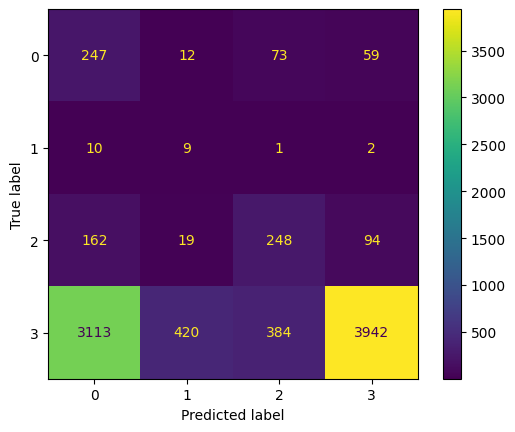

In [78]:
gb_model1 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', QuantileTransformer()),
    ('classifier', GradientBoostingClassifier(random_state=42, learning_rate=0.001, max_depth=1, n_estimators=25))
])

y_pred = cross_val_predict(gb_model1, X, y, cv=5)

cm2 = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()

# Model 2

In [72]:
params = {'classifier__n_estimators': [10, 20, 25, 30, 40, 50, 75, 100, 125]}

gb_param_test3 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', QuantileTransformer()),
    ('classifier', GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=3))
])

gs4 = GridSearchCV(gb_param_test3, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)


In [73]:
gs4.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__n_estimators': [10, 20, ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [74]:
results4 = pd.DataFrame(gs4.cv_results_)

In [75]:
results4

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_precision_nonDRNA,split1_test_precision_nonDRNA,split2_test_precision_nonDRNA,split3_test_precision_nonDRNA,...,std_test_recall_RNA,rank_test_recall_RNA,split0_test_recall_DRNA,split1_test_recall_DRNA,split2_test_recall_DRNA,split3_test_recall_DRNA,split4_test_recall_DRNA,mean_test_recall_DRNA,std_test_recall_DRNA,rank_test_recall_DRNA
0,5.473976,0.048737,0.091815,0.022703,10,{'classifier__n_estimators': 10},0.966466,0.966610,0.960102,0.976109,...,0.064670,9,0.25,0.50,0.25,0.4,0.2,0.32,0.112250,1
1,10.797078,0.104105,0.089968,0.014264,20,{'classifier__n_estimators': 20},0.969747,0.967980,0.959150,0.974152,...,0.050377,4,0.25,0.25,0.25,0.4,0.2,0.27,0.067823,2
2,13.491659,0.115341,0.082114,0.016014,25,{'classifier__n_estimators': 25},0.972403,0.964344,0.957895,0.973684,...,0.055775,8,0.25,0.25,0.25,0.4,0.0,0.23,0.128841,3
3,15.826019,0.344329,0.078754,0.008353,30,{'classifier__n_estimators': 30},0.969624,0.965406,0.961661,0.971026,...,0.056365,5,0.25,0.25,0.25,0.2,0.0,0.19,0.096954,4
4,20.242654,0.196698,0.075579,0.004337,40,{'classifier__n_estimators': 40},0.972397,0.965300,0.962412,0.971842,...,0.054640,2,0.25,0.25,0.25,0.2,0.0,0.19,0.096954,4
5,25.886828,0.222026,0.081487,0.009207,50,{'classifier__n_estimators': 50},0.971963,0.967417,0.963367,0.972450,...,0.050699,1,0.00,0.25,0.25,0.2,0.0,0.14,0.115758,6
6,39.696058,0.484835,0.106172,0.047961,75,{'classifier__n_estimators': 75},0.969834,0.969288,0.960456,0.970523,...,0.043851,7,0.00,0.25,0.00,0.2,0.0,0.09,0.111355,7
7,57.537836,0.478840,0.099803,0.010226,100,{'classifier__n_estimators': 100},0.966102,0.967836,0.959851,0.968185,...,0.042018,3,0.00,0.25,0.00,0.2,0.0,0.09,0.111355,7
8,65.321834,4.724904,0.075941,0.016215,125,{'classifier__n_estimators': 125},0.966163,0.966739,0.958815,0.965075,...,0.040367,6,0.00,0.25,0.00,0.2,0.0,0.09,0.111355,7


In [76]:
results4[[x for x in list(results4.columns) if 'rank' in x]].sum(axis=1).sort_values()

5    43
4    45
7    47
8    47
6    54
1    69
3    71
2    74
0    86
dtype: int64

In [77]:
results4[[x for x in list(results4.columns) if 'mean' in x]]

,mean_fit_time,mean_score_time,mean_test_precision_nonDRNA,mean_test_precision_DNA,mean_test_precision_RNA,mean_test_precision_DRNA,mean_test_specificity_nonDRNA,mean_test_specificity_DNA,mean_test_specificity_RNA,mean_test_specificity_DRNA,mean_test_recall_nonDRNA,mean_test_recall_DNA,mean_test_recall_RNA,mean_test_recall_DRNA
0,5.473976,0.091815,0.965878,0.125155,0.360115,0.023091,0.787427,0.818299,0.931212,0.963293,0.717011,0.554982,0.610092,0.32
1,10.797078,0.089968,0.966424,0.139827,0.375632,0.030686,0.781016,0.835077,0.933750,0.978113,0.751494,0.575463,0.625385,0.27
2,13.491659,0.082114,0.965244,0.146168,0.375630,0.029137,0.770349,0.841383,0.934234,0.980507,0.760274,0.583090,0.619615,0.23
3,15.826019,0.078754,0.965057,0.148140,0.387595,0.028882,0.766077,0.845310,0.936651,0.983813,0.770199,0.577929,0.625348,0.19
4,20.242654,0.075579,0.966259,0.158463,0.402828,0.039424,0.769280,0.854949,0.939311,0.988487,0.787631,0.585589,0.638755,0.19
5,25.886828,0.081487,0.966835,0.167104,0.402449,0.033333,0.770355,0.863278,0.939191,0.990311,0.798574,0.585557,0.640641,0.14
6,39.696058,0.106172,0.965285,0.180211,0.400902,0.034286,0.753271,0.876367,0.941005,0.993959,0.818169,0.580526,0.621502,0.09
7,57.537836,0.099803,0.963385,0.193283,0.407761,0.050794,0.734037,0.890526,0.941850,0.995783,0.834456,0.560045,0.629103,0.09
8,65.321834,0.075941,0.961917,0.206652,0.414567,0.061905,0.718017,0.901831,0.943785,0.997036,0.848961,0.547225,0.625275,0.09


#4 wins

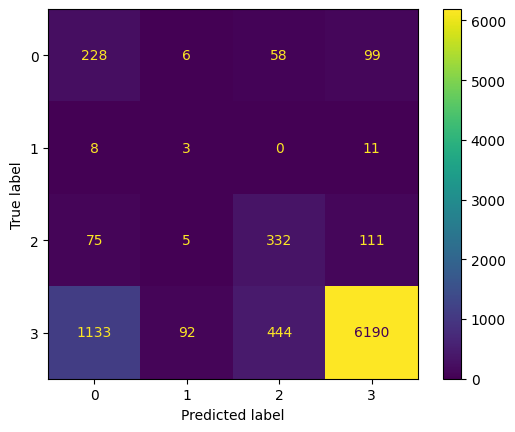

In [79]:
gb_model2 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', QuantileTransformer()),
    ('classifier', GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=40))
])

y_pred = cross_val_predict(gb_model2, X, y, cv=5)

cm2 = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()